In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Generate some example data using Data Generator

In [2]:
np.random.seed(42)
from causalnex.structure import data_generators as dg
sm = dg.generate_structure(num_nodes=2, degree=2)
sm.threshold_till_dag()
data = dg.generate_continuous_dataframe(sm, 
                                        n_samples=1000, 
                                        intercept=False, 
                                        seed=42, 
                                        noise_scale=0.1, 
                                        distribution="normal")

#### visualise the DGP

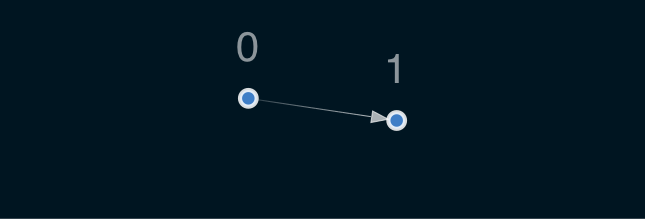

In [3]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import warnings
warnings.filterwarnings('ignore')

viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

### import the SM Regressor and other sklearn linear models

In [4]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from causalnex.structure.sklearn import StructureModelRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

##### Column 0 as y variable
- feature importances
- in sample R2

In [5]:
# True weights
for (i, j, w) in sm.edges(data="weight"):
    if j == 0:
        print(i, w)

COEFS: [0.36804304]


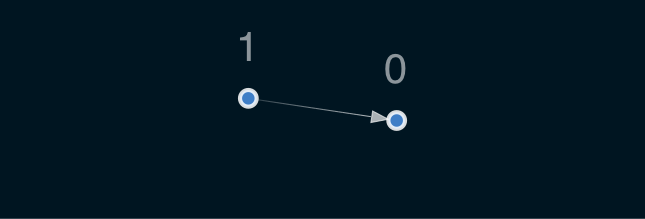

In [6]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

smr = StructureModelRegressor(alpha=0.0, threshold=0.0, enforce_dag=True, fit_intercept=True)
smr.fit(X, y)
# smr.predict(X)
print(f'COEFS: {smr.coef_}')
# print(f'MEAN R2: {cross_val_score(smr, X, y).mean():.3f}')

# visualise structure learned
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import warnings
warnings.filterwarnings('ignore')

viz = plot_structure(
    smr._graph, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

##### similar performance to linreg

In [7]:
lr = LinearRegression()
lr.fit(X, y)
print(f'COEFS: {lr.coef_}')
print(f'MEAN R2: {cross_val_score(lr, X, y).mean():.3f}')

COEFS: [0.36812487]
MEAN R2: 0.157


## More difficult test

2 -0.5
3 0.5
4 -0.5
5 -0.5


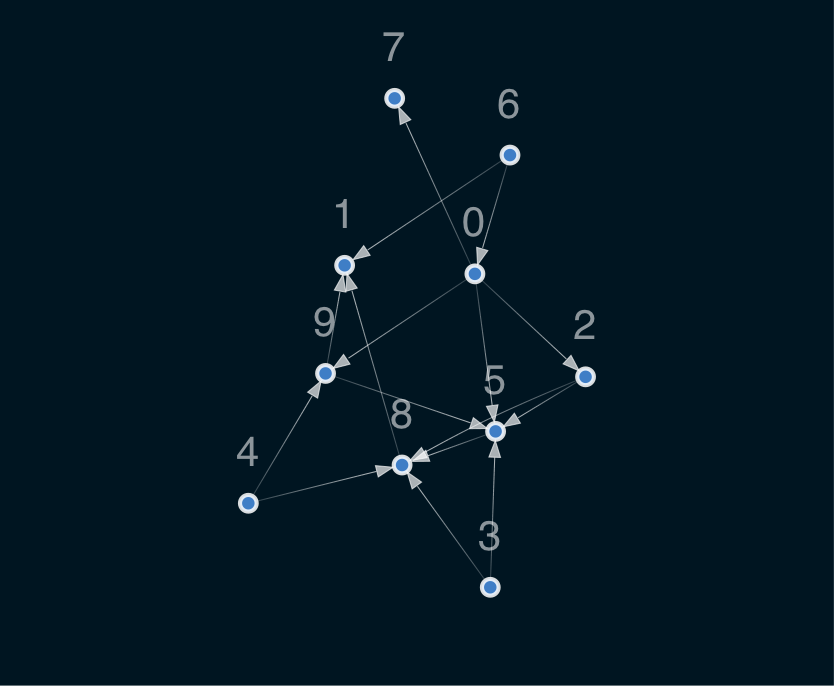

In [8]:
np.random.seed(42)
from causalnex.structure import data_generators as dg
sm = dg.generate_structure(num_nodes=10, degree=3)
sm.threshold_till_dag()
data = dg.generate_continuous_dataframe(sm, n_samples=1000, intercept=True, seed=42, noise_scale=1)

from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import warnings
warnings.filterwarnings('ignore')

node = 8
y = data.iloc[:, node]
X = data.drop(node, axis=1)
# True weights
for (i, j, w) in sm.edges(data="weight"):
    if j == node:
        print(i, w)

viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

COEFS: [ 0.         -0.14441717 -0.1199192   0.         -0.20733225 -0.27171272
 -0.27122772  0.         -0.32360542], INTERCEPT: 0.24292856454849243
MEAN R2: 0.582


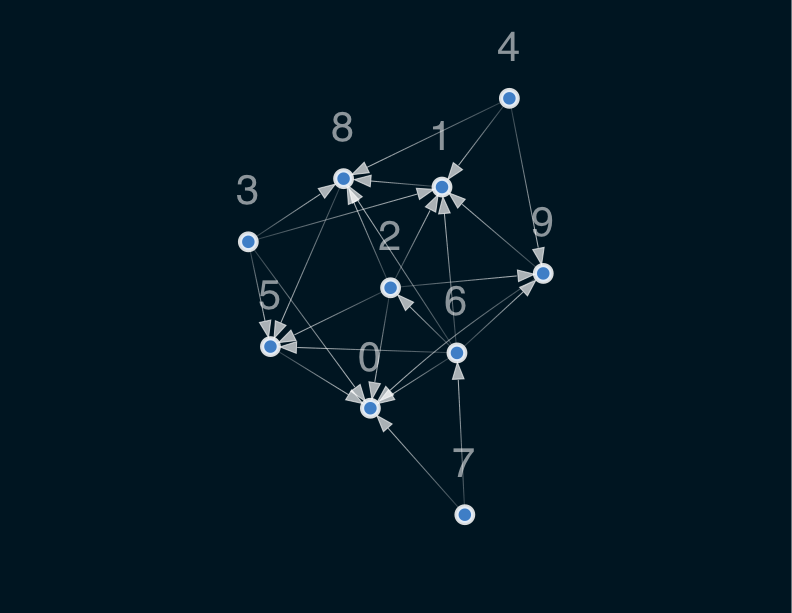

In [9]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

smr = StructureModelRegressor(alpha=0.0, fit_intercept=True, threshold=0.0, dependent_target=True, enforce_dag=True)
smr.fit(X, y)

print(f'COEFS: {smr.coef_}, INTERCEPT: {smr.intercept_}')
# raise ValueError
print(f'MEAN R2: {cross_val_score(smr, X, y).mean():.3f}')

# visualise structure learned
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import warnings
warnings.filterwarnings('ignore')

viz = plot_structure(
    smr._graph, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

In [10]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)
print(f'COEFS: {lr.coef_}, INTERCEPT: {lr.intercept_}')
print(f'MEAN R2: {cross_val_score(lr, X, y).mean():.3f}')

COEFS: [-0.00698626 -0.14441713 -0.1199192  -0.09800842 -0.20733226 -0.27171273
 -0.27122766  0.01643915 -0.32360545], INTERCEPT: 0.24292838720478205
MEAN R2: 0.583


# High noise

2 -0.5
3 0.5
4 -0.5
5 -0.5


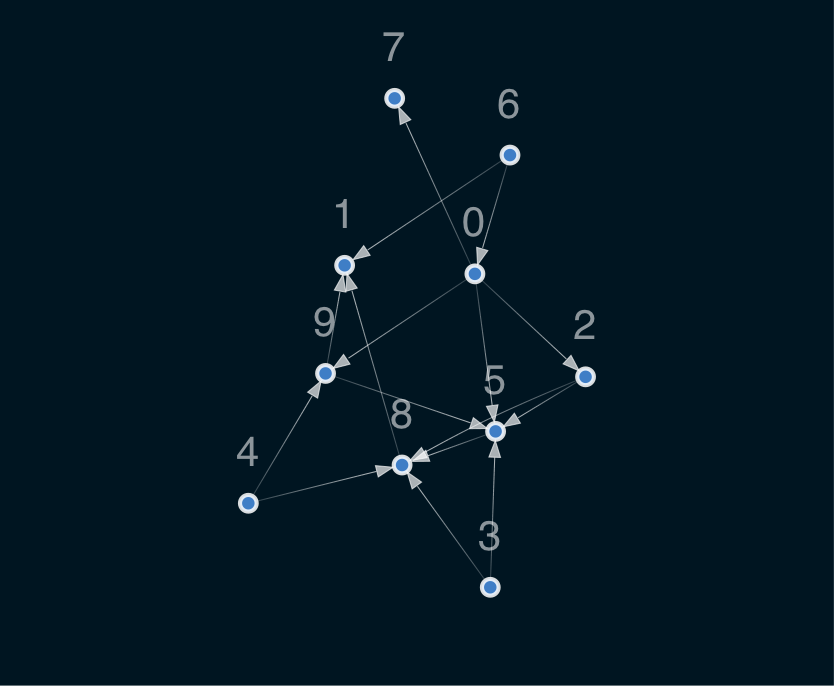

In [11]:
np.random.seed(42)
from causalnex.structure import data_generators as dg
sm = dg.generate_structure(num_nodes=10, degree=3)
sm.threshold_till_dag()
data = dg.generate_continuous_dataframe(sm, n_samples=1000, intercept=False, seed=42, noise_scale=10)

from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import warnings
warnings.filterwarnings('ignore')

node = 8
y = data.iloc[:, node]
X = data.drop(node, axis=1)
# True weights
for (i, j, w) in sm.edges(data="weight"):
    if j == node:
        print(i, w)

viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

COEFS: [ 0.         -0.14720742 -0.11681057 -0.10116336 -0.19976082 -0.26397187
 -0.27439681  0.         -0.32235646], INTERCEPT: 0.0
MEAN R2: 0.582


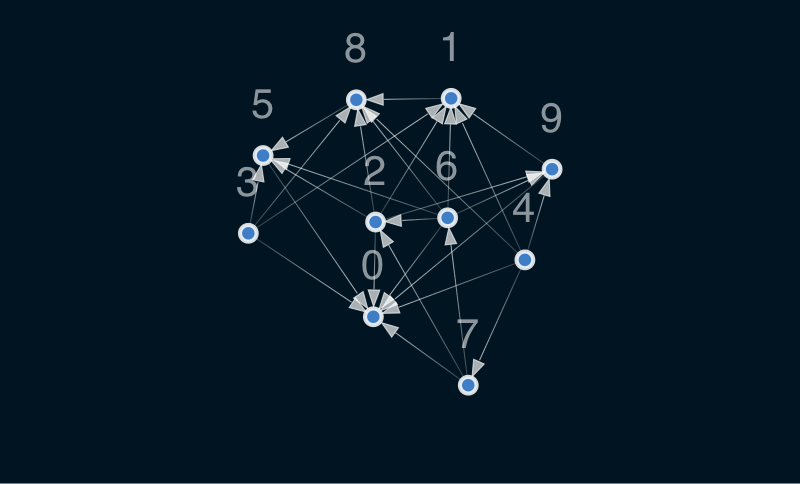

In [12]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

smr = StructureModelRegressor(alpha=0.0, fit_intercept=False, threshold=0.0, dependent_target=True, enforce_dag=True)
smr.fit(X, y)

print(f'COEFS: {smr.coef_}, INTERCEPT: {smr.intercept_}')
# raise ValueError
print(f'MEAN R2: {cross_val_score(smr, X, y).mean():.3f}')

# visualise structure learned
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import warnings
warnings.filterwarnings('ignore')

viz = plot_structure(
    smr._graph, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

In [13]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
print(f'COEFS: {lr.coef_}, INTERCEPT: {lr.intercept_}')
print(f'MEAN R2: {cross_val_score(lr, X, y).mean():.3f}')

COEFS: [-0.00784204 -0.14720744 -0.11681055 -0.10116337 -0.19976082 -0.26397186
 -0.27439682  0.02166669 -0.32235646], INTERCEPT: 0.0
MEAN R2: 0.586
